# Master Thesis

Datasets:
- medical dataset: https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions/data
- pii masking hugging face dataset: https://huggingface.co/datasets/ai4privacy/pii-masking-65k/viewer/default/train?row=2

Github:
- https://github.com/kkdresen/masterds_thesis

In [1]:
!pip install lime

### Packages

In [7]:
# Basic libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import random
import itertools
from collections import defaultdict

In [2]:
# Preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN



/Users/kyradresen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/kyradresen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


: 

In [2]:
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer

In [4]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.6 MB/s eta 0:00:0000:0100:01


In [5]:
# Models

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
import lightgbm as lgb

# Evaluation

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer


import warnings
warnings.filterwarnings("ignore")

/Users/kyradresen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/kyradresen/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


AttributeError: module 'pandas.core.strings' has no attribute 'StringMethods'

In [1]:
%matplotlib inline

### Load in Medical Data
* 4999 rows and 6 columns

In [8]:
path = "mtsamples.csv"
data = pd.read_csv(path)
print(data.shape)
data.head()

(4999, 6)


,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         4999 non-null   int64 
 1   description        4999 non-null   object
 2   medical_specialty  4999 non-null   object
 3   sample_name        4999 non-null   object
 4   transcription      4966 non-null   object
 5   keywords           3931 non-null   object
dtypes: int64(1), object(5)
memory usage: 234.5+ KB


### Missing Values

In [10]:
def count_nan_values(data_frame, column_names):
    """
    Counts the number of NaN values in the specified column(s) of the given DataFrame.

    Parameters:
    - data_frame (pd.DataFrame): The DataFrame to analyze.
    - column_names (str or list): The name of the column or a list of column names to check for NaN values.

    Returns:
    - A dictionary with column names as keys and the count of NaN values as values. If a single column name is provided,
      a direct count is returned.
    """
    if isinstance(column_names, str):
        # If a single column name is provided, return the count directly
        return data_frame[column_names].isna().sum()
    elif isinstance(column_names, list):
        # If a list of column names is provided, return a dictionary with counts
        return {column: data_frame[column].isna().sum() for column in column_names}
    else:
        raise ValueError("The column_names parameter should be either a string or a list of strings.")

In [11]:
count = count_nan_values(data, 'transcription')
print(f"Number of NaN values in 'column_name': {count}")

Number of NaN values in 'column_name': 33


In [12]:
# to identify the null values by descending order
data.isnull().sum().sort_values(ascending = False)

keywords             1068
transcription          33
Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
dtype: int64

As there are 33 rows with NaN values in transcription these should be removed, as transcription is the sole column we focus on in the rest of the research

### Drop rows and columns

The dataset contains of several categories, but we will need only transcription, and medical_specialty, which is the target disgnostics type.

In [13]:
data = data[['transcription', 'medical_specialty']]
data = data.drop(data[data['transcription'].isna()].index)
data.head(2)

,transcription,medical_specialty
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology
1,"PAST MEDICAL HISTORY:, He has difficulty climb...",Bariatrics


## Data review

In [14]:
data['medical_specialty'].value_counts()

medical_specialty
Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    61
Psychiatry / Psychology            53
Office Notes                       50
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                       

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer

# Ensure NLTK resources are downloaded (only need to do this once)
nltk.download('punkt')

def get_sentence_word_count(transcriptions):
    sentence_count = sum(len(sent_tokenize(text)) for text in transcriptions)
    words = [word for text in transcriptions for word in word_tokenize(text)]
    unique_words = set(words)
    return sentence_count, len(unique_words)

# Filter out rows where 'transcription' is NaN
data = data[data['transcription'].notna()]

# Convert 'transcription' column to a list of strings for processing
transcriptions = data['transcription'].tolist()

# Get sentence and unique word counts
sent_count, word_count = get_sentence_word_count(transcriptions)

print("Number of sentences in transcriptions column: " + str(sent_count))
print("Number of unique words in transcriptions column: " + str(word_count))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Number of sentences in transcriptions column: 147028
Number of unique words in transcriptions column: 41910


In [ ]:
# Ensure NLTK resources are downloaded (only need to do this once)
nltk.download('punkt')

def analyze_transcription_metrics(transcription):
    # Tokenize the transcription into sentences and words
    sentences = sent_tokenize(transcription)
    words = word_tokenize(transcription)

    # Calculate metrics
    word_count = len(words)
    mean_word_length = sum(len(word) for word in words) / word_count
    mean_sentence_length = sum(len(sentence.split()) for sentence in sentences) / len(sentences)
    length_of_sample_review = len(transcription)  # Length of the sample review

    return {
        "Word count": word_count,
        "Mean word length": mean_word_length,
        "Mean sentence length": mean_sentence_length,
        "Length of sample review": length_of_sample_review,
        "Number of words in review": word_count,  # This is the same as word_count
        "Avg length of words": mean_word_length,  # This is the same as mean_word_length
        "Avg length of sentences in review": mean_sentence_length,  # Same as mean_sentence_length
    }

# Assuming 'data' is your DataFrame and it has a 'transcription' column
# Filter out rows where 'transcription' is NaN
data = data[data['transcription'].notna()]

# Apply the analysis to each transcription and create a new DataFrame with the results
metrics = data['transcription'].apply(analyze_transcription_metrics)
metrics_df = pd.DataFrame(metrics.tolist())

# Calculate mean, min, and max for each metric
metrics_summary = pd.DataFrame({
    "Mean": metrics_df.mean(),
    "Min": metrics_df.min(),
    "Max": metrics_df.max()
})

print(metrics_summary)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                          Mean    Min           Max
Word count                          553.022755   3.00   3489.000000
Mean word length                      4.649651   3.25      7.333333
Mean sentence length                 16.914368   1.00    114.000000
Length of sample review            3052.314337  11.00  18425.000000
Number of words in review           553.022755   3.00   3489.000000
Avg length of words                   4.649651   3.25      7.333333
Avg length of sentences in review    16.914368   1.00    114.000000


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


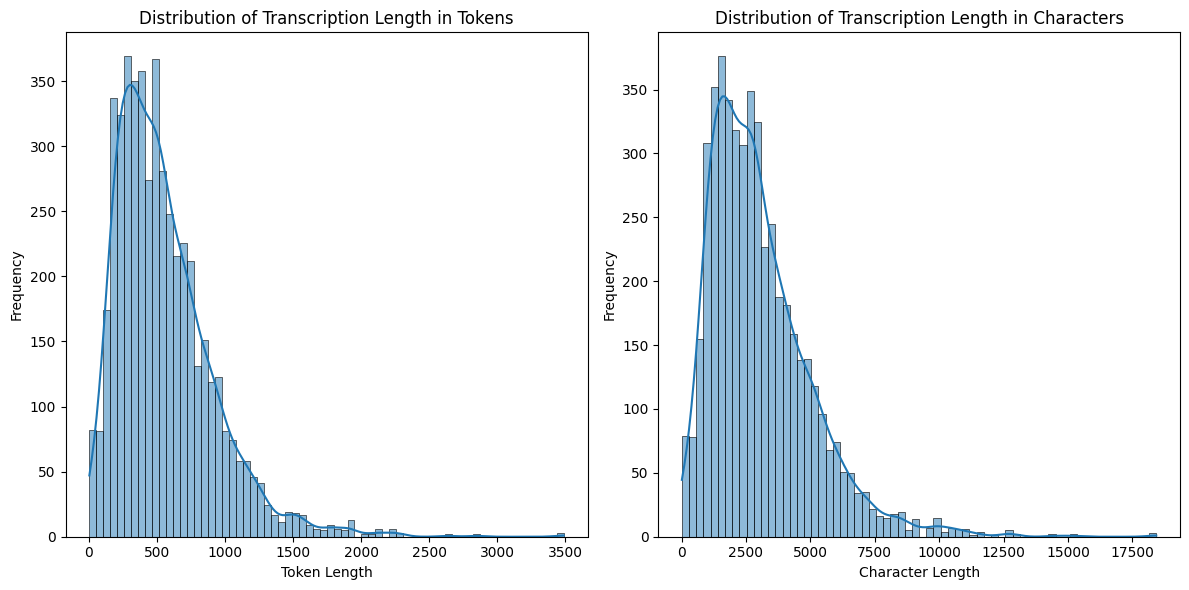

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure NLTK resources are downloaded (only need to do this once)
nltk.download('punkt')

def analyze_transcription_lengths(transcription):
    """
    Analyze the length of a transcription in both tokens and characters.

    :param transcription: The transcription text.
    :return: A dictionary with token and character lengths.
    """
    tokens = word_tokenize(transcription)
    token_length = len(tokens)
    character_length = len(transcription)

    return {
        "Token Length": token_length,
        "Character Length": character_length
    }

# Assuming 'data' is your DataFrame and it has a 'transcription' column
# Filter out rows where 'transcription' is NaN
data = data[data['transcription'].notna()]

# Apply the analysis to each transcription and create a new DataFrame with the results
length_metrics = data['transcription'].apply(analyze_transcription_lengths)
length_metrics_df = pd.DataFrame(length_metrics.tolist())

def plot_transcription_length_distributions(length_metrics_df):
    """
    Plot the distribution of transcription lengths in tokens and characters.

    :param length_metrics_df: DataFrame with 'Token Length' and 'Character Length' columns.
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot token length distribution
    sns.histplot(length_metrics_df['Token Length'], ax=ax[0], kde=True)
    ax[0].set_title('Distribution of Transcription Length in Tokens')
    ax[0].set_xlabel('Token Length')
    ax[0].set_ylabel('Frequency')

    # Plot character length distribution
    sns.histplot(length_metrics_df['Character Length'], ax=ax[1], kde=True)
    ax[1].set_title('Distribution of Transcription Length in Characters')
    ax[1].set_xlabel('Character Length')
    ax[1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Plotting the distributions
plot_transcription_length_distributions(length_metrics_df)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.tokenize import RegexpTokenizer

# Ensure all entries in "transcription" are strings
data["transcription"] = data["transcription"].astype(str)

# Create a list of tokens for each sentence
tokenizer = RegexpTokenizer(r'\w+')
data["tokens"] = data["transcription"].apply(tokenizer.tokenize)

all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))


2420937 words total, with a vocabulary size of 28581
Max sentence length is 3114


In [ ]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

# Ensure NLTK resources are downloaded (only need to do this once)
nltk.download('punkt')

def calculate_corpus_statistics(data):
    total_sentences = 0
    total_words = 0

    for transcription in data['transcription']:
        # Tokenize the transcription into sentences and words
        sentences = sent_tokenize(transcription)
        words = word_tokenize(transcription)

        # Update total counts
        total_sentences += len(sentences)
        total_words += len(words)

    return total_sentences, total_words

# Assuming 'data' is your DataFrame and it has a 'transcription' column
# Filter out rows where 'transcription' is NaN
data = data[data['transcription'].notna()]

# Calculate total sentences and words in the corpus
total_sentences, total_words = calculate_corpus_statistics(data)

print(f"Total sentences in the corpus: {total_sentences}")
print(f"Total words in the corpus: {total_words}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Total sentences in the corpus: 147028
Total words in the corpus: 2746311


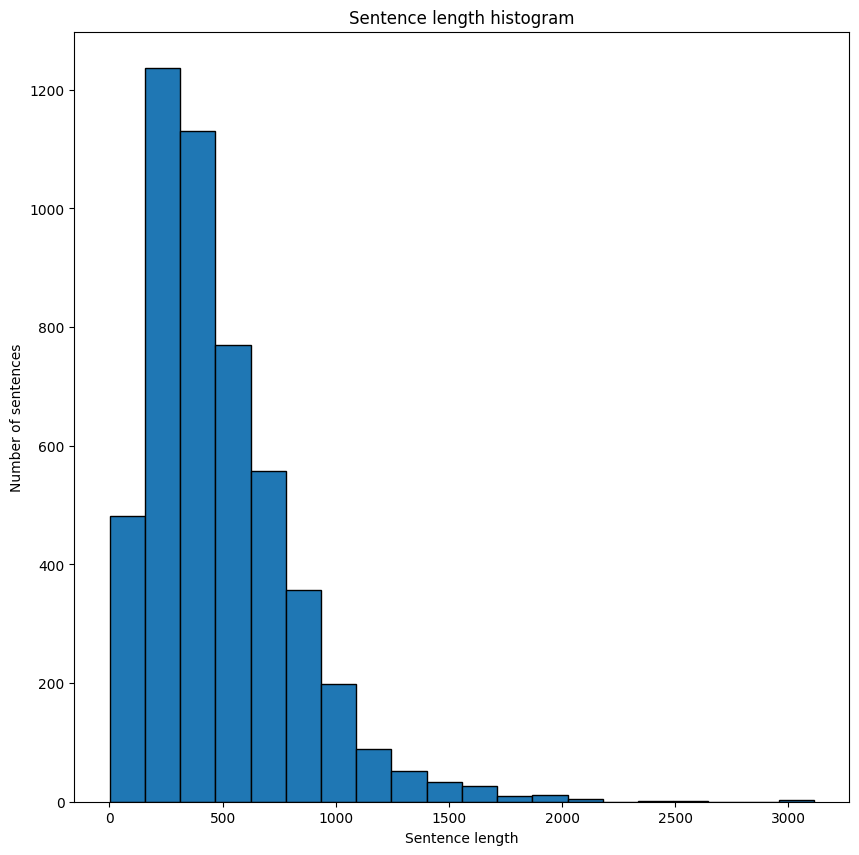

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.title('Sentence length histogram')
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths, edgecolor = 'black', bins = 20)
plt.show()

In [ ]:
print(f"Median sentence length {np.median(sentence_lengths)}")
print(f"Mean sentence length {round(np.mean(sentence_lengths), 2)}")

Median sentence length 421.5
Mean sentence length 487.5


### Filter on transcriptions between 10-520 tokens

In [ ]:
import pandas as pd
import numpy as np

def filter_and_sample_transcriptions(df, medical_specialty_column, transcription_column, min_tokens, max_tokens, samples_per_specialty):
    """
    Filters and randomly samples rows in a DataFrame based on the token length of transcriptions and medical specialty.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the transcriptions.
    - medical_specialty_column (str): The name of the column containing medical specialties.
    - transcription_column (str): The name of the column containing the transcriptions.
    - min_tokens (int): The minimum number of tokens a transcription must have.
    - max_tokens (int): The maximum number of tokens a transcription can have.
    - samples_per_specialty (int): Number of samples to randomly select from each specialty.

    Returns:
    - pd.DataFrame: A DataFrame filtered based on the specified token length and randomly sampled per specialty.
    """
    # Split the transcriptions into tokens based on whitespace and count them
    token_counts = df[transcription_column].apply(lambda x: len(x.split()))

    # Filter the DataFrame based on the token count criteria
    filtered_df = df[(token_counts >= min_tokens) & (token_counts <= max_tokens)]

    # Group by medical specialty and sample a number of entries from each group
    sampled_df = filtered_df.groupby(medical_specialty_column).apply(
        lambda x: x.sample(min(len(x), samples_per_specialty), random_state=1) if len(x) > 0 else x
    ).reset_index(drop=True)

    return sampled_df


In [ ]:
# Example usage (you'll need to replace 'your_dataframe' and 'your_transcription_column' with actual variables)
sampled_df = filter_and_sample_transcriptions(data, 'medical_specialty', 'transcription', 20, 300, 10)
sampled_df

,transcription,medical_specialty,tokens
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology,"[SUBJECTIVE, This, 23, year, old, white, femal..."
1,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...",Allergy / Immunology,"[ADMITTING, DIAGNOSIS, Kawasaki, disease, DISC..."
2,"HISTORY:, A 55-year-old female presents self-...",Allergy / Immunology,"[HISTORY, A, 55, year, old, female, presents, ..."
3,"PAST MEDICAL HISTORY: ,She had a negative str...",Bariatrics,"[PAST, MEDICAL, HISTORY, She, had, a, negative..."
4,"HISTORY OF PRESENT ILLNESS: ,I have seen ABC t...",Bariatrics,"[HISTORY, OF, PRESENT, ILLNESS, I, have, seen,..."
...,...,...,...
295,"PREOPERATIVE DIAGNOSIS: , Voluntary sterility....",Urology,"[PREOPERATIVE, DIAGNOSIS, Voluntary, sterility..."
296,"PHYSICAL EXAMINATION:, This 71-year-old man w...",Urology,"[PHYSICAL, EXAMINATION, This, 71, year, old, m..."
297,"CHIEF COMPLAINT:, Recurrent bladder tumor.,HI...",Urology,"[CHIEF, COMPLAINT, Recurrent, bladder, tumor, ..."
298,"CHIEF COMPLAINT: , Left flank pain and unable ...",Urology,"[CHIEF, COMPLAINT, Left, flank, pain, and, una..."


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
sampled_df['medical_specialty'].value_counts()

medical_specialty
 Nephrology                       10
 Letters                          10
 Surgery                          10
 Sleep Medicine                   10
 SOAP / Chart / Progress Notes    10
 Radiology                        10
 Podiatry                         10
 Pediatrics - Neonatal            10
 Pain Management                  10
 Orthopedic                       10
 Ophthalmology                    10
 Office Notes                     10
 Obstetrics / Gynecology          10
 Neurosurgery                     10
 Neurology                        10
 Urology                          10
 Dermatology                      10
 Hematology - Oncology            10
 General Medicine                 10
 Gastroenterology                 10
 Cardiovascular / Pulmonary       10
 Emergency Room Reports           10
 ENT - Otolaryngology             10
 Discharge Summary                10
 Consult - History and Phy.       10
 Bariatrics                        9
 Cosmetic / Plastic 

### NER recognizer to create dataframe that allows for finetuning

In [ ]:
'''import pandas as pd
from transformers import pipeline

def process_transcriptions(df, transcription_column):
    # Initialize the NER pipeline
    pipe = pipeline("token-classification", model="Clinical-AI-Apollo/Medical-NER", aggregation_strategy='simple')

    # Process each transcription in the specified column
    processed_data = []
    for text in df[transcription_column]:
        entities = pipe(text)
        # Mask the detected entities in the text
        masked_text = text
        for entity in reversed(entities):  # Reverse to avoid indexing issues while replacing
            start = entity['start']
            end = entity['end']
            masked_text = masked_text[:start] + "[MASK]" + masked_text[end:]

        # Collect data for each transcription
        processed_data.append({
            'masked_text': masked_text,
            'unmasked_text': text,
            'token_entity_labels': [entity['entity_group'] for entity in entities],
            'tokenised_unmasked_text': [t['word'] for t in pipe.tokenizer(text).tokens()]
        })

    # Create and return DataFrame with results
    return pd.DataFrame(processed_data)

# Example usage
data = {
    'transcriptions': [
        "45 year old woman diagnosed with CAD",
        "A 34-year-old male with a history of myocardial infarction.",
        "Patient reports severe allergic reaction to penicillin."
    ]
}
input_df = pd.DataFrame(data)
processed_df = process_transcriptions(input_df, 'transcriptions')'''

'import pandas as pd\nfrom transformers import pipeline\n\ndef process_transcriptions(df, transcription_column):\n    # Initialize the NER pipeline\n    pipe = pipeline("token-classification", model="Clinical-AI-Apollo/Medical-NER", aggregation_strategy=\'simple\')\n\n    # Process each transcription in the specified column\n    processed_data = []\n    for text in df[transcription_column]:\n        entities = pipe(text)\n        # Mask the detected entities in the text\n        masked_text = text\n        for entity in reversed(entities):  # Reverse to avoid indexing issues while replacing\n            start = entity[\'start\']\n            end = entity[\'end\']\n            masked_text = masked_text[:start] + "[MASK]" + masked_text[end:]\n\n        # Collect data for each transcription\n        processed_data.append({\n            \'masked_text\': masked_text,\n            \'unmasked_text\': text,\n            \'token_entity_labels\': [entity[\'entity_group\'] for entity in entities]

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline
pipe = pipeline("token-classification", model="Clinical-AI-Apollo/Medical-NER", aggregation_strategy='simple')
text='PREOPERATIVE DIAGNOSIS: , Morbid obesity. ,POSTOPERATIVE DIAGNOSIS: , Morbid obesity. ,PROCEDURE:, Laparoscopic Roux-en-Y gastric bypass, antecolic, antegastric with 25-mm EEA anastamosis, esophagogastroduodenoscopy. ,ANESTHESIA: , General with endotracheal intubation. ,INDICATIONS FOR PROCEDURE: , This is a 50-year-old male who has been overweight for many years and has tried multiple different weight loss diets and programs. The patient has now begun to have comorbidities related to the obesity. The patient has attended our bariatric seminar and met with our dietician and psychologist. The patient has read through our comprehensive handout and understands the risks and benefits of bypass surgery as evidenced by the signing of our consent form.,PROCEDURE IN DETAIL: , The risks and benefits were explained to the patient. Consent was obtained. The patient was taken to the operating room and placed supine on the operating room table. General anesthesia was administered with endotracheal intubation. A Foley catheter was placed for bladder decompression. All pressure points were carefully padded, and sequential compression devices were placed on the legs. The abdomen was prepped and draped in standard, sterile, surgical fashion. Marcaine was injected into the umbilicus'
result = pipe(text)



# Load model directly
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("Clinical-AI-Apollo/Medical-NER")
model = AutoModelForTokenClassification.from_pretrained("Clinical-AI-Apollo/Medical-NER")

config.json:   0%|          | 0.00/5.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/736M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
print(result)

[{'entity_group': 'SEVERITY', 'score': 0.35846373, 'word': 'Morbid', 'start': 25, 'end': 32}, {'entity_group': 'DISEASE_DISORDER', 'score': 0.4948957, 'word': 'obesity', 'start': 32, 'end': 40}, {'entity_group': 'SEVERITY', 'score': 0.32556018, 'word': 'Morbid', 'start': 69, 'end': 76}, {'entity_group': 'DISEASE_DISORDER', 'score': 0.43508127, 'word': 'obesity', 'start': 76, 'end': 84}, {'entity_group': 'DETAILED_DESCRIPTION', 'score': 0.8358668, 'word': 'Laparoscopic', 'start': 98, 'end': 111}, {'entity_group': 'THERAPEUTIC_PROCEDURE', 'score': 0.7133927, 'word': 'Roux-en-Y gastric bypass', 'start': 111, 'end': 136}, {'entity_group': 'DETAILED_DESCRIPTION', 'score': 0.8339487, 'word': 'antecolic,', 'start': 137, 'end': 148}, {'entity_group': 'BIOLOGICAL_STRUCTURE', 'score': 0.4324117, 'word': 'ante', 'start': 148, 'end': 153}, {'entity_group': 'DETAILED_DESCRIPTION', 'score': 0.680278, 'word': 'gastric', 'start': 153, 'end': 160}, {'entity_group': 'DISTANCE', 'score': 0.41304636, 'wor

In [ ]:
from transformers import pipeline
import pandas as pd

# Load the NER pipeline once to avoid reloading it every function call
ner_pipeline = pipeline("token-classification", model="Clinical-AI-Apollo/Medical-NER", aggregation_strategy='simple')

def mask_specific_entities(df, input_column, entity_groups_to_mask):
    # Function to mask entities in a single transcription
    def mask_text(text):
        entities = ner_pipeline(text)
        masked_text = text
        offset = 0
        for entity in sorted(entities, key=lambda x: x['start']):
            if entity['entity_group'].lower() in entity_groups_to_mask:
                start = entity['start'] + offset
                end = entity['end'] + offset
                entity_tag = entity['entity_group']
                masked_word = f"[{entity_tag}]"
                masked_text = masked_text[:start] + masked_word + masked_text[end:]
                offset += len(masked_word) - (end - start)

        return masked_text

    # Apply the masking function to each row in the specified column
    df['masked_transcriptions'] = df[input_column].apply(mask_text)
    return df

# Example usage:
data = sampled_df
df = pd.DataFrame(data)
input_column = 'transcription'
entity_groups_to_mask = ['disease_disorder', 'sign_symptom', 'age', 'sex']

# Process the DataFrame
masked_df = mask_specific_entities(df, input_column, entity_groups_to_mask)
print(masked_df)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


                                         transcription      medical_specialty  \
0    SUBJECTIVE:,  This 23-year-old white female pr...   Allergy / Immunology   
1    ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...   Allergy / Immunology   
2    HISTORY:,  A 55-year-old female presents self-...   Allergy / Immunology   
3    PAST MEDICAL HISTORY:  ,She had a negative str...             Bariatrics   
4    HISTORY OF PRESENT ILLNESS: ,I have seen ABC t...             Bariatrics   
..                                                 ...                    ...   
295  PREOPERATIVE DIAGNOSIS: , Voluntary sterility....                Urology   
296  PHYSICAL EXAMINATION:,  This 71-year-old man w...                Urology   
297  CHIEF COMPLAINT:,  Recurrent bladder tumor.,HI...                Urology   
298  CHIEF COMPLAINT: , Left flank pain and unable ...                Urology   
299  PROCEDURE: , Circumcision.,PRE-PROCEDURE DIAGN...                Urology   

                           

In [ ]:
masked_df

,transcription,medical_specialty,tokens,masked_transcriptions
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology,"[SUBJECTIVE, This, 23, year, old, white, femal...","SUBJECTIVE:, This[AGE] white[SEX] presents wi..."
1,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...",Allergy / Immunology,"[ADMITTING, DIAGNOSIS, Kawasaki, disease, DISC...","ADMITTING DIAGNOSIS: ,[DISEASE_DISORDER].,DISC..."
2,"HISTORY:, A 55-year-old female presents self-...",Allergy / Immunology,"[HISTORY, A, 55, year, old, female, presents, ...","HISTORY:, A[AGE][SEX] presents self-referred ..."
3,"PAST MEDICAL HISTORY: ,She had a negative str...",Bariatrics,"[PAST, MEDICAL, HISTORY, She, had, a, negative...","PAST MEDICAL HISTORY: ,She had a negative str..."
4,"HISTORY OF PRESENT ILLNESS: ,I have seen ABC t...",Bariatrics,"[HISTORY, OF, PRESENT, ILLNESS, I, have, seen,...","HISTORY OF PRESENT ILLNESS: ,I have seen ABC t..."
...,...,...,...,...
295,"PREOPERATIVE DIAGNOSIS: , Voluntary sterility....",Urology,"[PREOPERATIVE, DIAGNOSIS, Voluntary, sterility...","PREOPERATIVE DIAGNOSIS: , Voluntary[SIGN_SYMPT..."
296,"PHYSICAL EXAMINATION:, This 71-year-old man w...",Urology,"[PHYSICAL, EXAMINATION, This, 71, year, old, m...","PHYSICAL EXAMINATION:, This[AGE][SEX] went to..."
297,"CHIEF COMPLAINT:, Recurrent bladder tumor.,HI...",Urology,"[CHIEF, COMPLAINT, Recurrent, bladder, tumor, ...","CHIEF COMPLAINT:, Recurrent bladder[DISEASE_D..."
298,"CHIEF COMPLAINT: , Left flank pain and unable ...",Urology,"[CHIEF, COMPLAINT, Left, flank, pain, and, una...","CHIEF COMPLAINT: , Left flank[SIGN_SYMPTOM] an..."


## Inbetween output to open and review

In [ ]:
# Specify the path to save the CSV file
file_path = 'output.csv'

# Save the DataFrame to CSV
masked_df.to_csv(file_path, index=False)  # Setting index=False to avoid saving the index as a separate column

print(f"DataFrame is successfully saved to {file_path}")

DataFrame is successfully saved to output.csv


### Standard PII Redacter

In [ ]:
from transformers import pipeline
import pandas as pd

# Load the PII pipeline once to avoid reloading it every function call
pii_pipeline = pipeline("token-classification", model="Isotonic/deberta-v3-base_finetuned_ai4privacy_v2", aggregation_strategy='simple')

def redact_pii(df, input_column, pii_groups_to_mask):
    """
    Function to redact personally identifiable information (PII) from a DataFrame column using a specified PII NER model.

    Parameters:
    df: DataFrame containing the data to be processed.
    input_column: String specifying the column containing text to process.
    pii_groups_to_mask: List of PII entity groups to mask (e.g., ['SSN', 'CREDIT_CARD', 'PHONE_NUMBER']).

    Returns:
    DataFrame with an additional column 'pii_masked_transcriptions' containing the PII-redacted text.
    """
    def redact_text(text):
        pii_entities = pii_pipeline(text)
        pii_masked_text = text
        offset = 0
        for entity in sorted(pii_entities, key=lambda x: x['start']):
            if entity['entity_group'].lower() in pii_groups_to_mask:
                start = entity['start'] + offset
                end = entity['end'] + offset
                entity_tag = entity['entity_group']
                masked_word = f"[{entity_tag}]"
                pii_masked_text = pii_masked_text[:start] + masked_word + pii_masked_text[end:]
                offset += len(masked_word) - (end - start)

        return pii_masked_text

    # Apply the redaction function to each row in the specified column
    df['pii_masked_transcriptions'] = df[input_column].apply(redact_text)
    return df


config.json:   0%|          | 0.00/6.10k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/736M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.28k [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

In [ ]:
# Example usage setup (assuming `df` has already been processed by the medical NER function and has 'masked_transcriptions'):

df = pd.DataFrame(masked_df)
input_column = 'masked_transcriptions'
pii_groups_to_mask = ['city', 'state']

# Apply PII redaction
pii_redacted_df = redact_pii(df, input_column, pii_groups_to_mask)
print(pii_redacted_df)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


                                         transcription      medical_specialty  \
0    SUBJECTIVE:,  This 23-year-old white female pr...   Allergy / Immunology   
1    ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...   Allergy / Immunology   
2    HISTORY:,  A 55-year-old female presents self-...   Allergy / Immunology   
3    PAST MEDICAL HISTORY:  ,She had a negative str...             Bariatrics   
4    HISTORY OF PRESENT ILLNESS: ,I have seen ABC t...             Bariatrics   
..                                                 ...                    ...   
295  PREOPERATIVE DIAGNOSIS: , Voluntary sterility....                Urology   
296  PHYSICAL EXAMINATION:,  This 71-year-old man w...                Urology   
297  CHIEF COMPLAINT:,  Recurrent bladder tumor.,HI...                Urology   
298  CHIEF COMPLAINT: , Left flank pain and unable ...                Urology   
299  PROCEDURE: , Circumcision.,PRE-PROCEDURE DIAGN...                Urology   

                           

In [ ]:
pii_redacted_df

,transcription,medical_specialty,tokens,masked_transcriptions,pii_masked_transcriptions
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology,"[SUBJECTIVE, This, 23, year, old, white, femal...","SUBJECTIVE:, This[AGE] white[SEX] presents wi...","SUBJECTIVE:, This[AGE] white[SEX] presents wi..."
1,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...",Allergy / Immunology,"[ADMITTING, DIAGNOSIS, Kawasaki, disease, DISC...","ADMITTING DIAGNOSIS: ,[DISEASE_DISORDER].,DISC...","ADMITTING DIAGNOSIS: ,[DISEASE_DISORDER].,DISC..."
2,"HISTORY:, A 55-year-old female presents self-...",Allergy / Immunology,"[HISTORY, A, 55, year, old, female, presents, ...","HISTORY:, A[AGE][SEX] presents self-referred ...","HISTORY:, A[AGE][SEX] presents self-referred ..."
3,"PAST MEDICAL HISTORY: ,She had a negative str...",Bariatrics,"[PAST, MEDICAL, HISTORY, She, had, a, negative...","PAST MEDICAL HISTORY: ,She had a negative str...","PAST MEDICAL HISTORY: ,She had a negative str..."
4,"HISTORY OF PRESENT ILLNESS: ,I have seen ABC t...",Bariatrics,"[HISTORY, OF, PRESENT, ILLNESS, I, have, seen,...","HISTORY OF PRESENT ILLNESS: ,I have seen ABC t...","HISTORY OF PRESENT ILLNESS: ,I have seen ABC t..."
...,...,...,...,...,...
295,"PREOPERATIVE DIAGNOSIS: , Voluntary sterility....",Urology,"[PREOPERATIVE, DIAGNOSIS, Voluntary, sterility...","PREOPERATIVE DIAGNOSIS: , Voluntary[SIGN_SYMPT...","PREOPERATIVE DIAGNOSIS: , Voluntary[SIGN_SYMPT..."
296,"PHYSICAL EXAMINATION:, This 71-year-old man w...",Urology,"[PHYSICAL, EXAMINATION, This, 71, year, old, m...","PHYSICAL EXAMINATION:, This[AGE][SEX] went to...","PHYSICAL EXAMINATION:, This[AGE][SEX] went to..."
297,"CHIEF COMPLAINT:, Recurrent bladder tumor.,HI...",Urology,"[CHIEF, COMPLAINT, Recurrent, bladder, tumor, ...","CHIEF COMPLAINT:, Recurrent bladder[DISEASE_D...","CHIEF COMPLAINT:, Recurrent bladder[DISEASE_D..."
298,"CHIEF COMPLAINT: , Left flank pain and unable ...",Urology,"[CHIEF, COMPLAINT, Left, flank, pain, and, una...","CHIEF COMPLAINT: , Left flank[SIGN_SYMPTOM] an...","CHIEF COMPLAINT: , Left flank[SIGN_SYMPTOM] an..."


## Label Density

In [ ]:
def calculate_label_density(df, masked_column):
    # Function to calculate label density for a single masked text
    def label_density(text):
        # Tokenize text and get entities
        entities = ner_pipeline(text)
        tokenized_text = ner_pipeline.tokenizer.tokenize(text)

        # Calculate density
        if len(tokenized_text) > 0:
            density = len(entities) / len(tokenized_text)
        else:
            density = 0  # Avoid division by zero for empty texts
        return density

    # Apply the label density function to each row in the masked column
    df['label_density'] = df[masked_column].apply(label_density)

    # Calculate the average label density across all rows
    average_density = df['label_density'].mean()

    return df, average_density

In [ ]:
# Calculate label densities on the masked transcriptions
processed_df, avg_density = calculate_label_density(masked_df, 'masked_transcriptions')

In [ ]:
avg_density

0.1680825400831514

In [ ]:
processed_df

,transcription,medical_specialty,tokens,masked_transcriptions,label_density
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology,"[SUBJECTIVE, This, 23, year, old, white, femal...","SUBJECTIVE:, This[AGE] white[SEX] presents wi...",0.163043
1,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...",Allergy / Immunology,"[ADMITTING, DIAGNOSIS, Kawasaki, disease, DISC...","ADMITTING DIAGNOSIS: ,[DISEASE_DISORDER].,DISC...",0.188139
2,"HISTORY:, A 55-year-old female presents self-...",Allergy / Immunology,"[HISTORY, A, 55, year, old, female, presents, ...","HISTORY:, A[AGE][SEX] presents self-referred ...",0.092262
3,"PAST MEDICAL HISTORY: ,She had a negative str...",Bariatrics,"[PAST, MEDICAL, HISTORY, She, had, a, negative...","PAST MEDICAL HISTORY: ,She had a negative str...",0.189555
4,"HISTORY OF PRESENT ILLNESS: ,I have seen ABC t...",Bariatrics,"[HISTORY, OF, PRESENT, ILLNESS, I, have, seen,...","HISTORY OF PRESENT ILLNESS: ,I have seen ABC t...",0.085526
...,...,...,...,...,...
295,"PREOPERATIVE DIAGNOSIS: , Voluntary sterility....",Urology,"[PREOPERATIVE, DIAGNOSIS, Voluntary, sterility...","PREOPERATIVE DIAGNOSIS: , Voluntary[SIGN_SYMPT...",0.173913
296,"PHYSICAL EXAMINATION:, This 71-year-old man w...",Urology,"[PHYSICAL, EXAMINATION, This, 71, year, old, m...","PHYSICAL EXAMINATION:, This[AGE][SEX] went to...",0.212471
297,"CHIEF COMPLAINT:, Recurrent bladder tumor.,HI...",Urology,"[CHIEF, COMPLAINT, Recurrent, bladder, tumor, ...","CHIEF COMPLAINT:, Recurrent bladder[DISEASE_D...",0.165803
298,"CHIEF COMPLAINT: , Left flank pain and unable ...",Urology,"[CHIEF, COMPLAINT, Left, flank, pain, and, una...","CHIEF COMPLAINT: , Left flank[SIGN_SYMPTOM] an...",0.147700


### Quality Assurance conducted with GPT/BERT

## Test Run: Multi-Label Classification after Medical PII Redaction

In [ ]:
import torch

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
def factorize_medical_specialty(df, column_name):
    """
    Transforms the medical specialty classes into integer codes.

    Parameters:
    - df: DataFrame containing the medical specialty data.
    - column_name: The name of the column to factorize.

    Returns:
    - df: Updated DataFrame with a new column 'medical_specialty_code'.
    """
    # Factorize the medical specialty and create a new column
    df['medical_specialty_code'] = pd.factorize(df[column_name])[0]
    return df

In [ ]:
# Factorize the 'medical_specialty' column
updated_df = factorize_medical_specialty(masked_df, 'medical_specialty')

In [ ]:
updated_df

,transcription,medical_specialty,tokens,masked_transcriptions,label_density,medical_specialty_code
0,"SUBJECTIVE:, This 23-year-old white female pr...",Allergy / Immunology,"[SUBJECTIVE, This, 23, year, old, white, femal...","SUBJECTIVE:, This[AGE] white[SEX] presents wi...",0.163043,0
1,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...",Allergy / Immunology,"[ADMITTING, DIAGNOSIS, Kawasaki, disease, DISC...","ADMITTING DIAGNOSIS: ,[DISEASE_DISORDER].,DISC...",0.188139,0
2,"HISTORY:, A 55-year-old female presents self-...",Allergy / Immunology,"[HISTORY, A, 55, year, old, female, presents, ...","HISTORY:, A[AGE][SEX] presents self-referred ...",0.092262,0
3,"PAST MEDICAL HISTORY: ,She had a negative str...",Bariatrics,"[PAST, MEDICAL, HISTORY, She, had, a, negative...","PAST MEDICAL HISTORY: ,She had a negative str...",0.189555,1
4,"HISTORY OF PRESENT ILLNESS: ,I have seen ABC t...",Bariatrics,"[HISTORY, OF, PRESENT, ILLNESS, I, have, seen,...","HISTORY OF PRESENT ILLNESS: ,I have seen ABC t...",0.085526,1
...,...,...,...,...,...,...
164,"PREOPERATIVE DIAGNOSIS: , Phimosis.,POSTOPERAT...",Urology,"[PREOPERATIVE, DIAGNOSIS, Phimosis, POSTOPERAT...","PREOPERATIVE DIAGNOSIS: ,[SIGN_SYMPTOM][DISEAS...",0.185286,37
165,"EPIDIDYMECTOMY,OPERATIVE NOTE: ,The patient w...",Urology,"[EPIDIDYMECTOMY, OPERATIVE, NOTE, The, patient...","EPIDIDYMECTOMY,OPERATIVE NOTE: ,The patient w...",0.255034,37
166,"CONSULT FOR PROSTATE CANCER,The patient return...",Urology,"[CONSULT, FOR, PROSTATE, CANCER, The, patient,...","CONSULT FOR[DISEASE_DISORDER],The patient retu...",0.098930,37
167,"OPERATIVE NOTE: ,The patient was taken to the...",Urology,"[OPERATIVE, NOTE, The, patient, was, taken, to...","OPERATIVE NOTE: ,The patient was taken to the...",0.241573,37


In [ ]:
from transformers import RobertaModel, RobertaTokenizer
import torch

df=updated_df

# define X and y
X = df['masked_transcriptions'].tolist()
y = df['medical_specialty_code'].tolist()

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base').to(device)

# Tokenize X
inputs = tokenizer(X, padding=True, truncation=True, return_tensors="pt", max_length=256)

# generate embeddings in batches
def generate_embeddings(model, inputs, batch_size=16):
    model.eval()
    embeddings = []
    for i in range(0, inputs['input_ids'].size(0), batch_size):
        batch_input_ids = inputs['input_ids'][i:i+batch_size].to(device)
        batch_attention_mask = inputs['attention_mask'][i:i+batch_size].to(device)
        with torch.no_grad():
            batch_outputs = model(batch_input_ids, attention_mask=batch_attention_mask)
            batch_embeddings = batch_outputs.last_hidden_state.mean(dim=1)
            embeddings.append(batch_embeddings.cpu().numpy())
    embeddings = np.concatenate(embeddings, axis=0)
    return embeddings

# Generate embeddings
embeddings = generate_embeddings(model, inputs, batch_size=16)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# apply oversampling
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
embeddings_resampled, labels_resampled = ros.fit_resample(embeddings, y)

In [ ]:
# train test val split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(embeddings_resampled, labels_resampled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

from torch import nn, optim
import torch.nn.functional as F

# MLP classifier
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the classifier, loss criterion, and optimizer
hidden_dim = 128
num_classes = 40
mlp_model = SimpleClassifier(input_dim=768, hidden_dim=hidden_dim, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Prepare data loaders
from torch.utils.data import DataLoader, TensorDataset
batch_size = 8
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32).to(device), torch.tensor(y_train, dtype=torch.long).to(device))
val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32).to(device), torch.tensor(y_val, dtype=torch.long).to(device))
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [ ]:
# Training loop
best_val_loss = float('inf')
best_model_state = None

epochs = 30
for epoch in range(epochs):
    mlp_model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = mlp_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation for loss
    mlp_model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = mlp_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # Check if it's the lowest validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = mlp_model.state_dict() # Save the best model

Epoch 1, Training Loss: 3.7148, Validation Loss: 3.7022
Epoch 2, Training Loss: 3.6529, Validation Loss: 3.7018
Epoch 3, Training Loss: 3.6007, Validation Loss: 3.7198
Epoch 4, Training Loss: 3.5299, Validation Loss: 3.7468
Epoch 5, Training Loss: 3.4466, Validation Loss: 3.7403
Epoch 6, Training Loss: 3.3418, Validation Loss: 3.7108
Epoch 7, Training Loss: 3.2046, Validation Loss: 3.6895
Epoch 8, Training Loss: 3.0496, Validation Loss: 3.6551
Epoch 9, Training Loss: 2.8859, Validation Loss: 3.6298
Epoch 10, Training Loss: 2.7301, Validation Loss: 3.5980
Epoch 11, Training Loss: 2.5836, Validation Loss: 3.5812
Epoch 12, Training Loss: 2.4518, Validation Loss: 3.5677
Epoch 13, Training Loss: 2.3283, Validation Loss: 3.5646
Epoch 14, Training Loss: 2.2197, Validation Loss: 3.5677
Epoch 15, Training Loss: 2.1181, Validation Loss: 3.5908
Epoch 16, Training Loss: 2.0258, Validation Loss: 3.6047
Epoch 17, Training Loss: 1.9361, Validation Loss: 3.6173
Epoch 18, Training Loss: 1.8565, Validat

In [ ]:
# Save the best model
torch.save(best_model_state, 'simple_classifier.pth')

# Clear memory
del inputs, labels, outputs, train_data, val_data, train_loader, val_loader
torch.cuda.empty_cache()

In [ ]:
from sklearn.metrics import classification_report

# initialize the loaded model
loaded_model = SimpleClassifier(input_dim=768, hidden_dim=128, num_classes=40).to(device)

# Load the saved model parameters
loaded_model.load_state_dict(torch.load('simple_classifier.pth'))

# Ensure the model is in evaluation mode
loaded_model.eval()

# Test dataset preparation
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32).to(device), torch.tensor(y_test, dtype=torch.long).to(device))
test_loader = DataLoader(test_data, batch_size=8)

# Evaluate on the test set using the loaded model
test_preds, test_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = loaded_model(inputs)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

print("Classification Report on Test Set (Using Loaded Model):")
print(classification_report(test_labels, test_preds))
report = classification_report(test_labels, test_preds, output_dict=True)
macro_avg_f1 = report['macro avg']['f1-score']
weighted_avg_f1 = report['weighted avg']['f1-score']
print(f"Macro Average F1 Score: {macro_avg_f1}")
print(f"Weighted Average F1 Score: {weighted_avg_f1}")

Classification Report on Test Set (Using Loaded Model):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.50      1.00      0.67         1
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         4
          16       1.00      1.00      1.00         1
          17       0.00      0.00      0.00         1
          18       0.50  

## Results of Multi-Label Classification Set Up

* When the set up is run over a sampled_df that only consists of 169 rows (which is a datafrme where almost every medical specialty occus 5 times and is within the scope of 20-300 tokens) the model yields a result of Macro F1 of 0.11 for both masked and unmasked transcription column
* For the entire original unmasked transcription column F1 is around ±0.74

In [ ]:
import pandas as pd
from nltk.tokenize import word_tokenize

# Ensure NLTK resources are downloaded (if not already done)
#nltk.download('punkt')

# Function to count occurrences of specific words
def count_specific_words(data, words):
    # Tokenize the 'transcription' text into individual words for each row
    data['tokens'] = data['transcription'].apply(lambda x: word_tokenize(x.lower()))

    # Count occurrences of each specified word
    word_counts = {word: sum(data['tokens'].apply(lambda tokens: tokens.count(word))) for word in words}
    return word_counts

# Words to count
words_to_count = ['female', 'male', 'age', 'old']

# Count specific words
word_counts = count_specific_words(data, words_to_count)

# Count occurrences of specific phrases
phrase_counts = {
    "lived in": data['transcription'].str.contains('lived in', case=False, na=False).sum(),
}

# Print results
print("Word Counts:")
for word, count in word_counts.items():
    print(f"{word}: {count}")

print("\nPhrase Counts:")
for phrase, count in phrase_counts.items():
    print(f"{phrase}: {count}")


Word Counts:
female: 1440
male: 1085
age: 822
old: 390

Phrase Counts:
lived in: 11


## Data Transformation: Tokenisation

* The data needs to be normalised to ensure proper tokenization
* The tokenization is needed to train the PII redaction models on the sensitive tokens that differ for the medical dataset vs the huggingface dataset
* The PII redaction model recognizes weight (e.g. BMI) metrics as age for example

### Text Normalisation to apply Tokenisation

In [ ]:
import pandas as pd
import re
import warnings

def remove_punctuation_and_numbers(data_frame, column_name):
    """
    Removes punctuation and numbers from a specified column in a pandas DataFrame.

    Parameters:
    - data_frame (pd.DataFrame): The DataFrame containing the data to be cleaned.
    - column_name (str): The name of the column from which punctuation and numbers will be removed.

    Returns:
    - pd.DataFrame: A copy of the DataFrame with punctuation and numbers removed from the specified column.
    """
    # Suppress warnings locally within this function
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        # Make a copy of the DataFrame to avoid modifying the original
        df_cleaned = data_frame.copy()

        # Remove punctuation and numbers from the specified column
        df_cleaned[column_name] = df_cleaned[column_name].apply(lambda x: " ".join(re.findall('[\w]+', str(x))))
        df_cleaned[column_name] = df_cleaned[column_name].str.replace('\d+', '', regex=True)

        return df_cleaned


In [ ]:
# Example usage:
# Assuming 'df' is your DataFrame and 'transcription' is the column you want to clean:
data = remove_punctuation_and_numbers(data, 'transcription')
data.head(3)

,transcription,medical_specialty,tokens
0,SUBJECTIVE This year old white female present...,Allergy / Immunology,"[subjective, :, ,, this, 23-year-old, white, f..."
1,PAST MEDICAL HISTORY He has difficulty climbin...,Bariatrics,"[past, medical, history, :, ,, he, has, diffic..."
2,HISTORY OF PRESENT ILLNESS I have seen ABC tod...,Bariatrics,"[history, of, present, illness, :, ,, i, have,..."


In [ ]:
import pandas as pd
from nltk.tokenize import WhitespaceTokenizer

def tokenise_text_column(data_frame, column_name):
    """
    Tokenizes the text in a specified column of a pandas DataFrame using whitespace
    tokenizer and stores the tokenized lists in a new column named 'tokenised'.

    Parameters:
    - data_frame (pd.DataFrame): The DataFrame containing the text data to be tokenized.
    - column_name (str): The name of the column containing text data to tokenize.

    Returns:
    - pd.DataFrame: A copy of the DataFrame with an additional column 'tokenised' that contains
                    the tokenized lists of the specified text column.
    """
    # Ensure a copy of the DataFrame is made to avoid modifying the original
    df_copy = data_frame.copy()

    # Initialize the WhitespaceTokenizer
    tokenizer = WhitespaceTokenizer()

    # Tokenize the specified column and store the results in a new column 'tokenised'
    df_copy['tokenised'] = df_copy.apply(lambda row: tokenizer.tokenize(str(row[column_name])), axis=1)

    return df_copy

In [ ]:

# Example usage:
# Assuming 'df' is your DataFrame and 'transcription' is the column you want to tokenize:
data = tokenise_text_column(data, 'transcription')
data.head(3)

,transcription,medical_specialty,tokens,tokenised
0,SUBJECTIVE This year old white female present...,Allergy / Immunology,"[subjective, :, ,, this, 23-year-old, white, f...","[SUBJECTIVE, This, year, old, white, female, p..."
1,PAST MEDICAL HISTORY He has difficulty climbin...,Bariatrics,"[past, medical, history, :, ,, he, has, diffic...","[PAST, MEDICAL, HISTORY, He, has, difficulty, ..."
2,HISTORY OF PRESENT ILLNESS I have seen ABC tod...,Bariatrics,"[history, of, present, illness, :, ,, i, have,...","[HISTORY, OF, PRESENT, ILLNESS, I, have, seen,..."


#### Remove Stopwords, as we need to retrain the PII redaction models to recognize the sensitive (non) PII tokens

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Removing stop words
def remove_stop_words(df, attribute):
    stop = stopwords.words('english')
    df['stemmed_without_stop'] = df[attribute].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))
    return df

In [ ]:
data = remove_stop_words(data, 'tokenised')
data.head(2)

,transcription,medical_specialty,tokens,tokenised,stemmed_without_stop
0,SUBJECTIVE This year old white female present...,Allergy / Immunology,"[subjective, :, ,, this, 23-year-old, white, f...","[SUBJECTIVE, This, year, old, white, female, p...",SUBJECTIVE This year old white female presents...
1,PAST MEDICAL HISTORY He has difficulty climbin...,Bariatrics,"[past, medical, history, :, ,, he, has, diffic...","[PAST, MEDICAL, HISTORY, He, has, difficulty, ...",PAST MEDICAL HISTORY He difficulty climbing st...


### Reduction of corpus

In [ ]:
total_word_count = data['transcription'].str.split().str.len().sum()
print(f'The word count of all transcription is: {int(total_word_count)}')

The word count of all transcription is: 2321187


In [ ]:
def calculate_normalized_word_reduction(data_frame, column_name, original_total_word_count):
    """
    Calculates and prints the total word count of a specified column after normalization
    and the percentage reduction compared to an original total word count.

    Parameters:
    - data_frame (pd.DataFrame): The DataFrame containing the normalized text data.
    - column_name (str): The name of the column containing the normalized text data.
    - original_total_word_count (int): The total word count before normalization.

    Returns:
    - None
    """
    # Calculate total word count after normalization
    total_word_count_normalized = data_frame[column_name].str.split().str.len().sum()

    # Calculate the percentage reduction
    reduction_percentage = (original_total_word_count - total_word_count_normalized) / original_total_word_count * 100

    # Print results
    print(f'The word count of transcription after normalized is: {int(total_word_count_normalized)}')
    print(f'{round(reduction_percentage, 2)}% less word')

In [ ]:
# Example usage:
# Assuming 'df' is your DataFrame, 'stemmed_without_stop' is the column after normalization,
#and 'total_word_count' is the original total word count:
calculate_normalized_word_reduction(data, 'stemmed_without_stop', total_word_count)


The word count of transcription after normalized is: 1491651
35.74% less word


### HuggingFace EDA

* 42757 rows and four columns

In [ ]:
# Path to your JSONL file
file_path = '/content/drive/MyDrive/00 UvA MASTER DATA SCIENCE /00. Thesis /Thesis Data/PII43k_original.jsonl'

# Reading JSONL file directly into a DataFrame
df = pd.read_json(file_path, lines=True)

# Displaying the DataFrame
df.head()
print(df.shape)

(42757, 4)


In [ ]:
df['unmasked_text']

0        In our video conference, discuss the role of e...
1        Could you draft a letter for Dietrich, Schulis...
2        Discuss the options for Jeffery Pfeffer who wa...
3        13. Write a press release announcing Gayle Wat...
4        9. Develop an inventory management plan for Ev...
                               ...                        
42752    Please write an article on the effectiveness o...
42753    Write a report on the most common online threa...
42754    Write a blog post for Stanton LLC about the ro...
42755    14. Calculate the return on investment for Con...
42756    Please write an email to Roberta Gutmann V at ...
Name: unmasked_text, Length: 42757, dtype: object